### Importación de Librerías

In [ ]:
# Tratameinto de datos
import pandas as pd
# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de datos

Vamos a tratar las columnas de fechas como tipo de dato `datetime` 

In [2]:
df = pd.read_csv('../data/raw/autorenew.csv', parse_dates=['dateCrawled', 'dateCreated', 'lastSeen']) # otra opción para pasar a tipo datetime las fechas

## Análisis preliminar

In [3]:
df.tail()

,dateCrawled,name,seller,offerType,price,vehicleType,yearOfRegistration,gearbox,powerCV,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
371523,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,private,offer,2200,NaN,2005,NaN,0.0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14,0,39576,2016-04-06 00:46:52
371524,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,private,offer,1199,convertible,2000,automatic,100.0,fortwo,125000,3,petrol,smart,no,2016-03-05,0,26135,2016-03-11 18:17:12
371525,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,private,offer,9200,bus,1996,manually,101.0,transporter,150000,3,diesel,volkswagen,no,2016-03-19,0,87439,2016-04-07 07:15:26
371526,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,private,offer,3400,combi,2002,manually,99.0,golf,150000,6,diesel,volkswagen,NaN,2016-03-20,0,40764,2016-03-24 12:45:21
371527,2016-03-07 19:39:19,BMW_M135i_vollausgestattet_NP_52.720____Euro,private,offer,28990,NaN,2013,manually,316.0,m_reihe,50000,8,petrol,bmw,no,2016-03-07,0,73326,2016-03-22 03:17:10


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  datetime64[ns]
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   vehicleType          237765 non-null  object        
 6   yearOfRegistration   371528 non-null  int64         
 7   gearbox              351319 non-null  object        
 8   powerCV              371528 non-null  float64       
 9   model                351044 non-null  object        
 10  kilometer            371528 non-null  int64         
 11  monthOfRegistration  371528 non-null  int64         
 12  fuelType             338142 non-null  object        
 13  brand         

### Análisis de fechas

Comprobar los valores únicos de los años para las columnas de fechas

In [5]:
df['dateCrawled'].dt.year.unique()

array([2016], dtype=int32)

In [6]:
columnas_fechas = ['dateCrawled', 'dateCreated', 'lastSeen']

In [7]:
for col in columnas_fechas:
  print(f"Los valores únicos de los años para {col} son {df[col].dt.year.unique()}")

Los valores únicos de los años para dateCrawled son [2016]
Los valores únicos de los años para dateCreated son [2016 2015 2014]
Los valores únicos de los años para lastSeen son [2016]


Vemos que los datos se estrajeron exclusivamente en 2016, mientras que los anuncios son únicamnete de entre 2014 y 2016. Pir lo tanto, asumiremos que los vehículos más nuevos son de 2016. Más allá, estas columnas aportar poco valor adicional, así que las eliminaremos.

In [8]:
df = df.drop(columns=columnas_fechas)

## Duplicados

Es posible que un vehículo haya sido registrado múltiples veces en varias fechas

In [9]:
df.duplicated().sum()

np.int64(6624)

Efectivamente hay duplicados. Procedemos a eliminarlos.

In [10]:
df = df.drop_duplicates()

## Valores nulos

Comprobar el total de valores nulos que tenemos

In [11]:
df.isnull().sum().sort_values(ascending=False)

vehicleType            131462
notRepairedDamage       70776
fuelType                33084
model                   20294
gearbox                 19806
price                       0
name                        0
seller                      0
powerCV                     0
yearOfRegistration          0
offerType                   0
kilometer                   0
monthOfRegistration         0
brand                       0
nrOfPictures                0
postalCode                  0
dtype: int64

In [12]:
nulos = df.isnull().sum()
nulos[nulos > 0]

vehicleType          131462
gearbox               19806
model                 20294
fuelType              33084
notRepairedDamage     70776
dtype: int64

Veamos si son muchos o pocos nulos

In [13]:
nulos_porc = df.isna().mean() * 100
nulos_porc[nulos_porc > 0].round(2)

vehicleType          36.03
gearbox               5.43
model                 5.56
fuelType              9.07
notRepairedDamage    19.40
dtype: float64

Debemos gestionar adecuadamente los nulos, especialmente de columnas criticas como `notRepairedDamage`

## Variables numéricas

In [14]:
columnas_num = df.select_dtypes(include='number').columns

In [15]:
columnas_num

Index(['price', 'yearOfRegistration', 'powerCV', 'kilometer',
       'monthOfRegistration', 'nrOfPictures', 'postalCode'],
      dtype='object')

In [16]:
df.describe(include='number').T.round(2)

,count,mean,std,min,25%,50%,75%,max
price,364904.0,17502.27,3620372.48,0.0,1150.0,2950.0,7150.0,2.147484e+09
yearOfRegistration,364904.0,2004.58,93.55,1000.0,1999.0,2003.0,2008.0,9.999000e+03
powerCV,364904.0,113.93,190.97,0.0,69.0,104.0,148.0,1.972600e+04
kilometer,364904.0,125685.07,40090.32,5000.0,125000.0,150000.0,150000.0,1.500000e+05
monthOfRegistration,364904.0,5.73,3.71,0.0,3.0,6.0,9.0,1.200000e+01
nrOfPictures,364904.0,0.00,0.00,0.0,0.0,0.0,0.0,0.000000e+00
postalCode,364904.0,50944.55,25775.64,1067.0,30655.0,49688.0,71642.0,9.999800e+04


Observaciones rápidas:
- **nrOfPictures**: todas las entradas tienen un valor de 0. La eliminaremos.
- **postalCode**: podría tratarse como categórica ya que se trata de códigos postales. Pero no son muy útiles para el análisis ya que no conocemos el país o región al que hacen referencia. Por ello, decidimos eliminarla.

In [17]:
df = df.drop(columns=['nrOfPictures', 'postalCode'])

In [18]:
columnas_num = df.select_dtypes(include='number').columns

### Histogramas

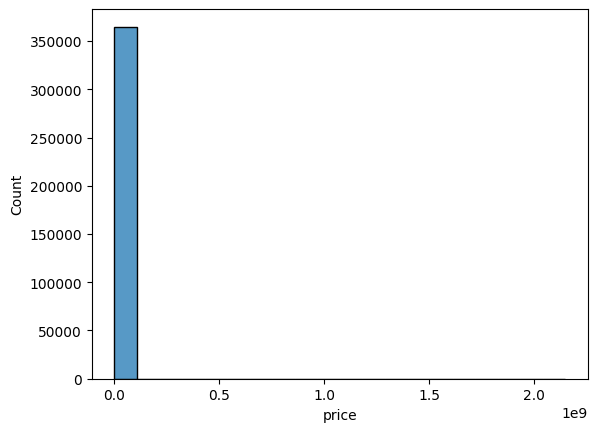

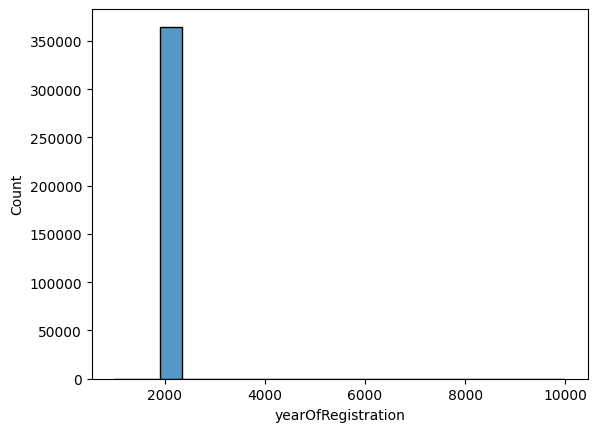

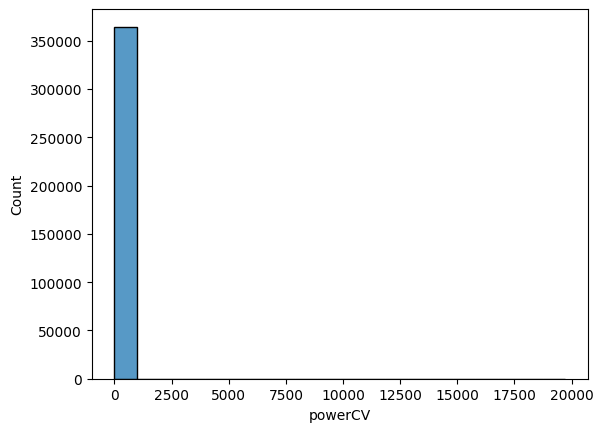

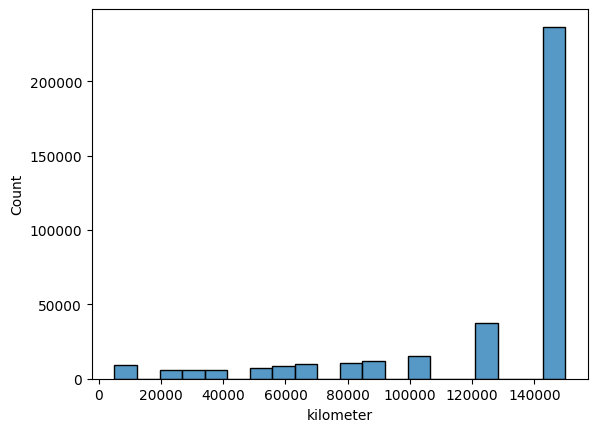

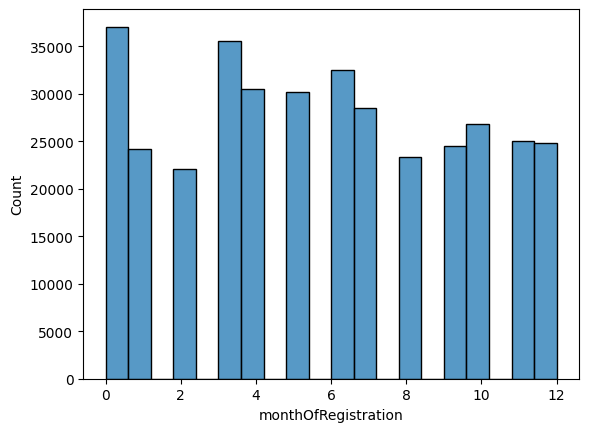

In [19]:
for col in columnas_num:
  plt.figure()
  sns.histplot(df[col], bins=20)
  plt.show()

### Boxplot

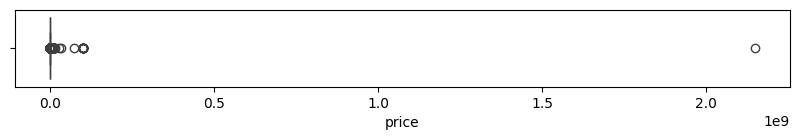

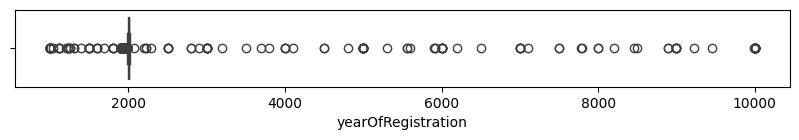

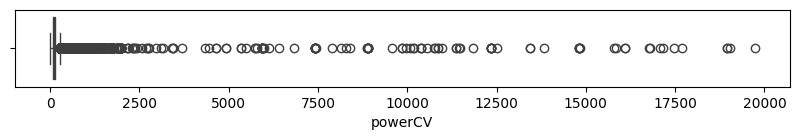

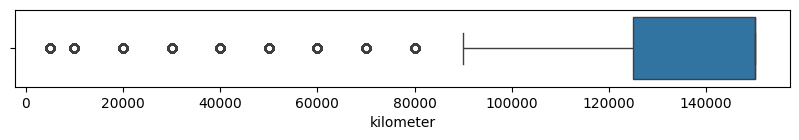

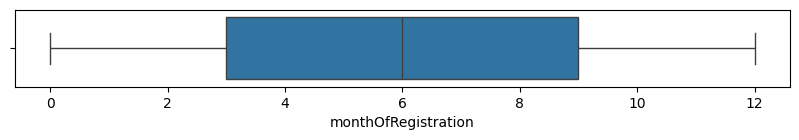

In [20]:
for col in columnas_num:
  plt.figure(figsize=(10, 1))
  sns.boxplot(x = df[col])
  plt.show()

## Variable Categóricas

In [21]:
df.describe(include=['object','category']).T

,count,unique,top,freq
name,364904,233531,Ford_Fiesta,650
seller,364904,2,private,364901
offerType,364904,2,offer,364892
vehicleType,233442,7,small car,78621
gearbox,345098,2,manually,269737
model,344610,251,golf,29539
fuelType,331820,7,petrol,220299
brand,364904,40,volkswagen,78227
notRepairedDamage,294128,2,no,258291


In [22]:
col_cat = df.select_dtypes(include=['object','category']).columns
col_cat

Index(['name', 'seller', 'offerType', 'vehicleType', 'gearbox', 'model',
       'fuelType', 'brand', 'notRepairedDamage'],
      dtype='object')

In [23]:
for col in col_cat:
 print(f"La columna {col.upper()} tiene un total de {df[col].nunique()} valores distintos")
 print(f"Los 10 valores más repetidos son:")
 display(df[col].value_counts().head(10))

La columna NAME tiene un total de 233531 valores distintos
Los 10 valores más repetidos son:


name
Ford_Fiesta            650
BMW_318i               623
Opel_Corsa             614
Volkswagen_Golf_1.4    598
BMW_316i               515
BMW_320i               490
Volkswagen_Polo        471
Renault_Twingo         444
Volkswagen_Golf        427
Volkswagen_Golf_1.6    411
Name: count, dtype: int64

La columna SELLER tiene un total de 2 valores distintos
Los 10 valores más repetidos son:


seller
private       364901
commercial         3
Name: count, dtype: int64

La columna OFFERTYPE tiene un total de 2 valores distintos
Los 10 valores más repetidos son:


offerType
offer      364892
request        12
Name: count, dtype: int64

La columna VEHICLETYPE tiene un total de 7 valores distintos
Los 10 valores más repetidos son:


vehicleType
small car      78621
combi          66264
bus            29640
convertible    22592
coupe          18757
suv            14249
other           3319
Name: count, dtype: int64

La columna GEARBOX tiene un total de 2 valores distintos
Los 10 valores más repetidos son:


gearbox
manually     269737
automatic     75361
Name: count, dtype: int64

La columna MODEL tiene un total de 251 valores distintos
Los 10 valores más repetidos son:


model
golf        29539
andere      26078
3er         20286
polo        12930
corsa       12360
astra       10595
passat      10077
a4          10026
c_klasse     8605
5er          8315
Name: count, dtype: int64

La columna FUELTYPE tiene un total de 7 valores distintos
Los 10 valores más repetidos son:


fuelType
petrol     220299
diesel     105088
lpg          5287
cng           561
hybrid        275
other         207
electro       103
Name: count, dtype: int64

La columna BRAND tiene un total de 40 valores distintos
Los 10 valores más repetidos son:


brand
volkswagen       78227
bmw              39567
opel             39359
mercedes_benz    34681
audi             32144
ford             25092
renault          17651
peugeot          10805
fiat              9511
seat              6908
Name: count, dtype: int64

La columna NOTREPAIREDDAMAGE tiene un total de 2 valores distintos
Los 10 valores más repetidos son:


notRepairedDamage
no     258291
yes     35837
Name: count, dtype: int64

In [24]:
# si quieres ver un porcentaje en el value_counts se puede hacer:
df['fuelType'].value_counts(normalize=True) * 100

fuelType
petrol     66.391116
diesel     31.670183
lpg         1.593334
cng         0.169068
hybrid      0.082876
other       0.062383
electro     0.031041
Name: proportion, dtype: float64

### Countplot

La columna name tiene demasiadas categorías:233531 


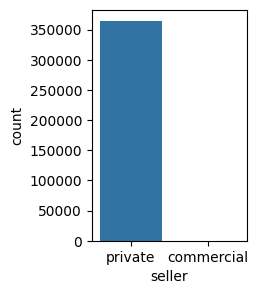

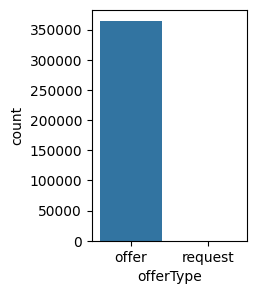

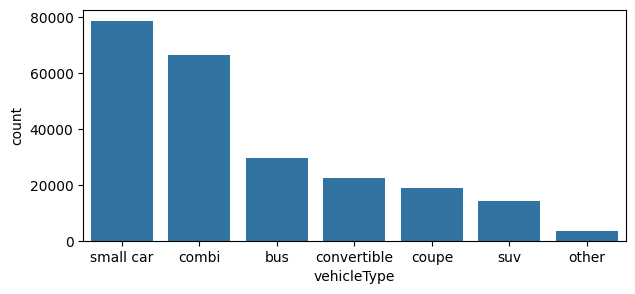

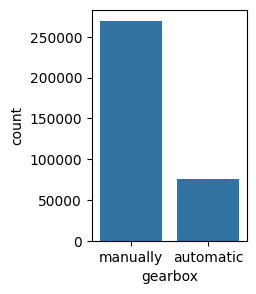

La columna model tiene demasiadas categorías:251 


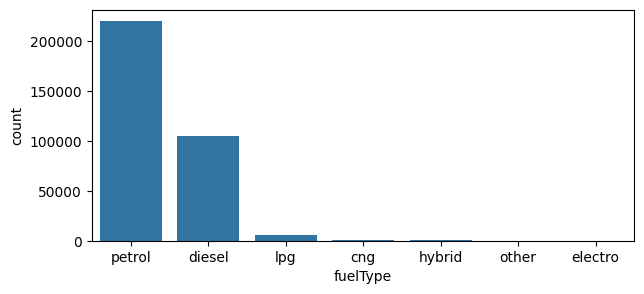

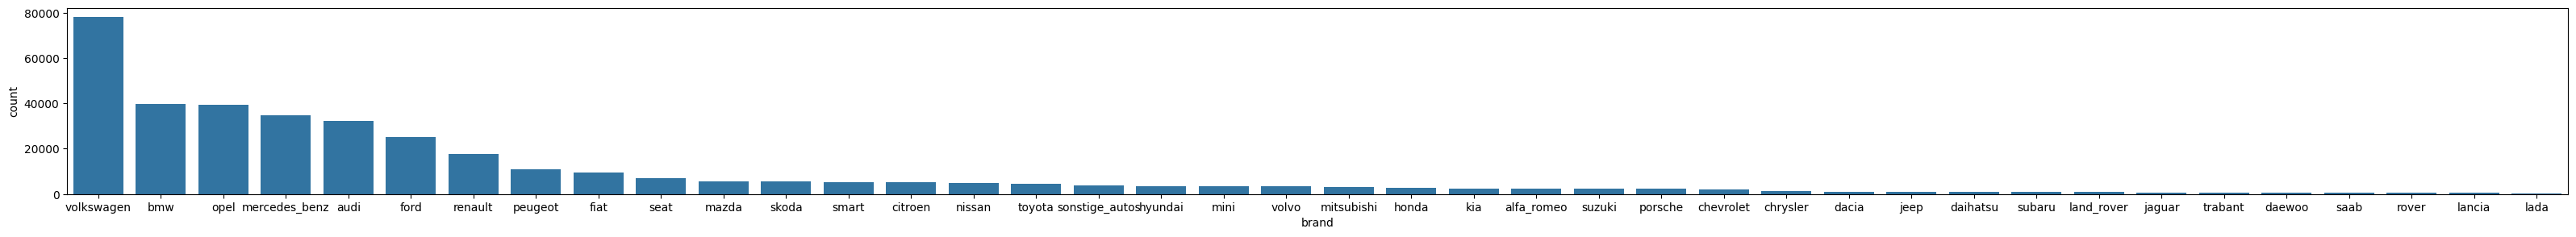

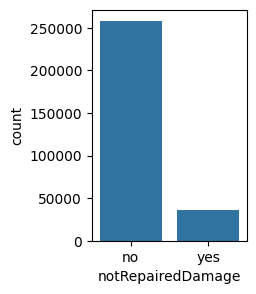

In [ ]:
for col in col_cat:
  if df[col].nunique() > 200:
   print(f"La columna {col.upper()} tiene demasiadas categorías:{df[col].nunique()} ")
   continue
  plt.figure(figsize=(df[col].nunique() ,3)) # ajusto el ancho al nº de categorías
  sns.countplot(x=df[col], order=df[col].value_counts().index)
  plt.show()